In [11]:
# Common Imports

import re
from collections.abc import Iterable
from typing import Optional, Literal

import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.figure import Figure
import numpy as np
import seaborn as sns

In [12]:
# Utility Functions

def is_iterable(iterable) -> bool:
    return isinstance(iterable, Iterable) and not isinstance(iterable, str)


def combined_len(lens: "np.ndarray[int]|int", N: Optional[int]) -> int:
    return lens.sum() if is_iterable(lens) else lens * N


def combined_mean(means: np.ndarray[float], lens: "np.ndarray[int]|int") -> float:
    return _combined_mean_with_len(means, lens, combined_len(lens, len(means)))


def _combined_mean_with_len(
    means: np.ndarray[float], ns: "np.ndarray[int]|int", pre_combined_len: int
) -> float:
    return (means * ns).sum() / pre_combined_len


def combined_stdev(
    stdevs: np.ndarray[float], means: np.ndarray[float], ns: "np.ndarray[int]|int"
) -> float:
    # assert(len(stdevs) == len(means))
    _combined_len = combined_len(ns, len(means))
    mean_diffs: np.ndarray[float] = means - _combined_mean_with_len(
        means, ns, _combined_len
    )
    _combined_stdevs: float = (ns * np.square(stdevs)).sum()
    _combined_meandiffs: float = (ns * np.square(mean_diffs)).sum()
    return np.sqrt((_combined_stdevs + _combined_meandiffs) / _combined_len)


def combined_mean_df(
    df: pd.DataFrame, mean_cols: list[str], n_col: str
) -> "pd.Series[float]":
    return df.apply(
        lambda row: combined_mean(row[mean_cols], row[n_col]), axis="columns"
    )


def combined_stdev_df(
    df: pd.DataFrame, stdev_cols: list[str], mean_cols: list[str], n_col: str
) -> "pd.Series[float]":
    return df.apply(
        lambda row: combined_stdev(row[stdev_cols], row[mean_cols], row[n_col]),
        axis="columns",
    )


def _validated(xss: tuple[Iterable[float]]) -> tuple[np.ndarray[np.longdouble], int]:
    axss = np.array(xss, dtype=np.longdouble)  # should be 2D
    assert axss.ndim == 2
    xss_len = {len(x) for x in axss}
    if len(xss_len) == 1:
        xss_len = xss_len.pop()
    else:
        raise ValueError("All supplied iterables must have the same length")
    return axss, xss_len


def total_variance(*xss: Iterable[float]) -> float:
    """
    Computes sum of variances of the components of vectors
    Returns:
    total_variance: float
    """
    axss, _ = _validated(xss)
    centroid: np.ndarray = np.mean(axss, axis=0)
    variances = np.mean((axss - centroid) ** 2, axis=1)
    return np.sum(variances)


def binned_mode(df: pd.DataFrame, bins: int|Iterable[float], axis: Literal['columns', 'rows']='columns') -> pd.DataFrame:
        if axis not in ('columns', 'rows'):
            raise ValueError(f"axis must be either 'rows' or 'columns', was {axis}")
        
        def cut(series: pd.Series):
            return pd.cut(series, bins)
        
        if axis == 'columns':
            cuts = [cut(df[col]) for col in df.columns] 
        else:
            cuts = [cut(df.loc[row]) for row in df.index]
        return [float(cut_series.mode()[0].mid) for cut_series in cuts]

In [13]:
sample_class_pattern = re.compile(r"[\w-]+ ([A-Za-z0-9]+)(_rep(\d))?")
L1MdF_pat = re.compile(r"L1Md_F\d+")

n_col = "No. Probes"
mismatch_col = "nt mismatch from consensus"

SampleGroupMapping = dict[str, list[str]]


def group_samples(col_names: pd.Index) -> SampleGroupMapping:
    sample_groups = {
        sample_class_pattern.match(col_name).group(1)
        for col_name in col_names
        if "_rep" in col_name
    }
    grouped_samples = {
        sample_info: [
            col_name
            for col_name in col_names
            if "_rep" in col_name
            and sample_info == sample_class_pattern.match(col_name).group(1)
        ]
        for sample_info in sample_groups
    }
    return grouped_samples


def combine_reps(
    divergence_data: pd.DataFrame, sample_groups: dict[str, list]
) -> pd.DataFrame:
    for group, cols in sample_groups.items():
        mean_cols = [col for col in cols if col.startswith("Mean")]
        stdev_cols = [col for col in cols if col.startswith("StDev")]
        divergence_data[f"Mean {group}"] = combined_mean_df(
            divergence_data, mean_cols, n_col
        )
        divergence_data[f"StDev {group}"] = combined_stdev_df(
            divergence_data, stdev_cols, mean_cols, n_col
        )
    return divergence_data


def add_teid(df: pd.DataFrame) -> pd.DataFrame:
    df["te_id"] = df.agg(
        lambda row: f"{row['Chr']}:{row['Start']}-{row['End']}{row['Strand']}({row['Feature']})",
        axis="columns",
    )
    return df


def add_index(df: pd.DataFrame):
    return add_teid(df).set_index("te_id")


def drop_samples(df: pd.DataFrame, samples: list[str]) -> pd.DataFrame:
    return df.drop(
        df.columns[df.columns.str.contains("|".join(samples))], axis="columns"
    )


def get_family_met_data(
    df: pd.DataFrame, te_families: Iterable[str]
) -> pd.DataFrame:
    return df.loc[df["Feature"].str.contains("|".join(te_families))]

In [14]:
divergence_data: pd.DataFrame = pd.read_excel(
    "./FeatureReport_nongene_TE_candidates.xlsx",
    dtype_backend="pyarrow",
    sheet_name="Sheet1",
)

In [15]:
# Also drop 1 Spocd1WT ctrl so that everything has 3 reps.
divergence_data = drop_samples(divergence_data, ["Spocd1WT_rep4"])
divergence_data = divergence_data.loc[
    :, ~divergence_data.columns.str.startswith("StDev")
]
divergence_data = add_index(divergence_data)
sample_mean_cols = divergence_data.columns[
    divergence_data.columns.str.startswith("Mean")
]

# Remove transposons where any entry does not have a methylation level
divergence_data[sample_mean_cols] = divergence_data[sample_mean_cols].fillna(0)
divergence_data = divergence_data[
    (divergence_data[sample_mean_cols] > 0).all(axis="columns")
]
sample_groups = group_samples(divergence_data.columns)
divergence_data = combine_reps(divergence_data, sample_groups)

In [16]:
samples_to_genotypes = {
    sample.replace("Mean ", ""): genotype
    for genotype, samples in sample_groups.items()
    for sample in samples
}

sort_genotypes = {
    "Spocd1WT": "Ctrl1_Spocd1WT",
    "Miwi2KO": "Mut1_Miwi2KO",
    "Tex15KO": "Mut2_Tex15KO",
    "C19KO": "Mut3_C19KO",
    "Spocd1KO": "Mut4_Spocd1KO",
    "Spocd1K464A": "Mut5_Spocd1K464A",
}

def plot_variance(data: pd.DataFrame, title: str) -> tuple[Figure, pd.DataFrame]:
    data = data.loc[
        :,
        data.columns.str.startswith("Mean")
        & data.columns.str.contains("_rep"),
    ]
    trim_len = len("Mean") + 1
    data = data.rename(columns=lambda col: col[trim_len:])
    data = data.dropna()
    data_t = data.transpose().sort_index()
    data_t["genotype"] = data_t.index.map(samples_to_genotypes.get)
    data_t_by_genotype = data_t.groupby(by="genotype")

    def dispersion_stats(df: pd.DataFrame) -> tuple[float, float, float]:
        row = list(row.values for _, row in df.iterrows())
        return total_variance(*row)
        
    variance_by_genotype = pd.DataFrame(
        list(
            data_t_by_genotype.apply(
                dispersion_stats,
                include_groups=False,
            )
        ),
        columns=[
            "Total Variance"
        ],
        index=list(data_t_by_genotype.groups.keys()),
    )
    variance_by_genotype = variance_by_genotype.rename(
        index=sort_genotypes
    ).sort_index()

    fig = plt.figure(figsize=(6, 10), dpi=100)

    ax1 = sns.barplot(variance_by_genotype.transpose(), ax=fig.subplots())
    ax1.set_xticks(
        ax1.get_xticks(),
        [
            label.get_text()[label.get_text().index("_") + 1 :]
            for label in ax1.get_xticklabels()
        ],
    )
    fig.suptitle(title)
    fig.savefig(f"./barplots/{title}_var.pdf", transparent=True)
    return fig, data_t.transpose()

In [19]:
from scipy.stats import ttest_ind


def median_plot_test(data: pd.DataFrame, title: str) -> Figure:
    data_set = data.loc[
        :,
        data.columns.str.startswith("Mean") & data.columns.str.contains("_rep")
    ]

    neg_ctrl_group, test_group, pos_ctrl_group = "Spocd1WT", "Spocd1K464A", "Spocd1KO"
    test_set = data_set.loc[:, data_set.columns.str.contains(test_group)]
    neg_ctrl_set = data_set.loc[:, data_set.columns.str.contains(neg_ctrl_group)]
    pos_ctrl_set = data_set.loc[:, data_set.columns.str.contains(pos_ctrl_group)]

    # Print descriptive statistics
    neg_ctrl_median, test_median, pos_ctrl_median = neg_ctrl_set.median(), test_set.median(), pos_ctrl_set.median()

    print(title)
    neg_test_ttest = ttest_ind(neg_ctrl_median, test_median)
    pos_test_ttest = ttest_ind(pos_ctrl_median, test_median)
    ttest_results = {
        f"T-test replicate medians ({neg_ctrl_group} ~ {test_group})": {neg_test_ttest},
        f"T-test replicate medians ({pos_ctrl_group} ~ {test_group})": {pos_test_ttest}
    }

    sets_medians = pd.concat([neg_ctrl_median, test_median, pos_ctrl_median], axis='columns')
    sets_medians.columns = [neg_ctrl_group, test_group, pos_ctrl_group]
    fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
    ax = sns.barplot(sets_medians, errorbar="se", ax=ax)
    ax = sns.stripplot(sets_medians, jitter=False, ax=ax)
    ax.set_ylim((0, 100))
    ax.set_title(title)
    fig.savefig(f"./barplots/{title}.pdf", transparent=True)
    return fig, ttest_results

L1Md_Gf
{'T-test replicate medians (Spocd1KO ~ Spocd1K464A)': {TtestResult(statistic=np.float64(-0.9228060518626215), pvalue=np.float64(0.4083334613293455), df=np.float64(4.0))},
 'T-test replicate medians (Spocd1WT ~ Spocd1K464A)': {TtestResult(statistic=np.float64(9.09063179432995), pvalue=np.float64(0.0008119466471968747), df=np.float64(4.0))}}
L1Md_T
{'T-test replicate medians (Spocd1KO ~ Spocd1K464A)': {TtestResult(statistic=np.float64(-1.4710918750597077), pvalue=np.float64(0.21522889218281235), df=np.float64(4.0))},
 'T-test replicate medians (Spocd1WT ~ Spocd1K464A)': {TtestResult(statistic=np.float64(16.26344905045685), pvalue=np.float64(8.364362988061349e-05), df=np.float64(4.0))}}
L1Md_A
{'T-test replicate medians (Spocd1KO ~ Spocd1K464A)': {TtestResult(statistic=np.float64(1.6017131539560792), pvalue=np.float64(0.18447650102355562), df=np.float64(4.0))},
 'T-test replicate medians (Spocd1WT ~ Spocd1K464A)': {TtestResult(statistic=np.float64(22.073999304273066), pvalue=np.fl

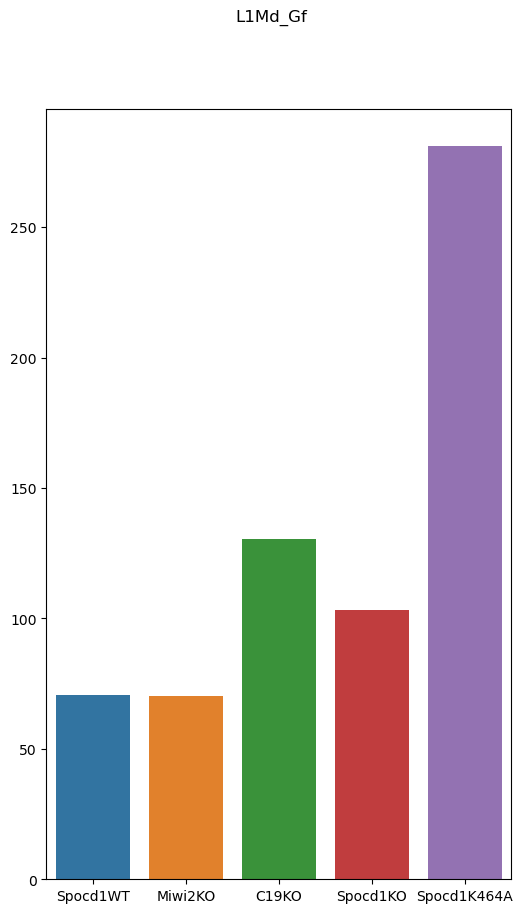

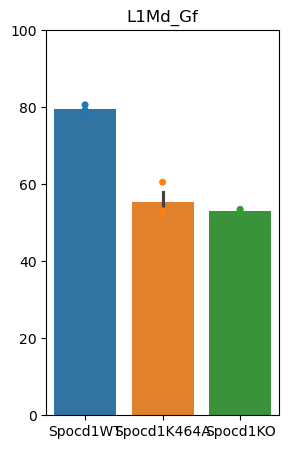

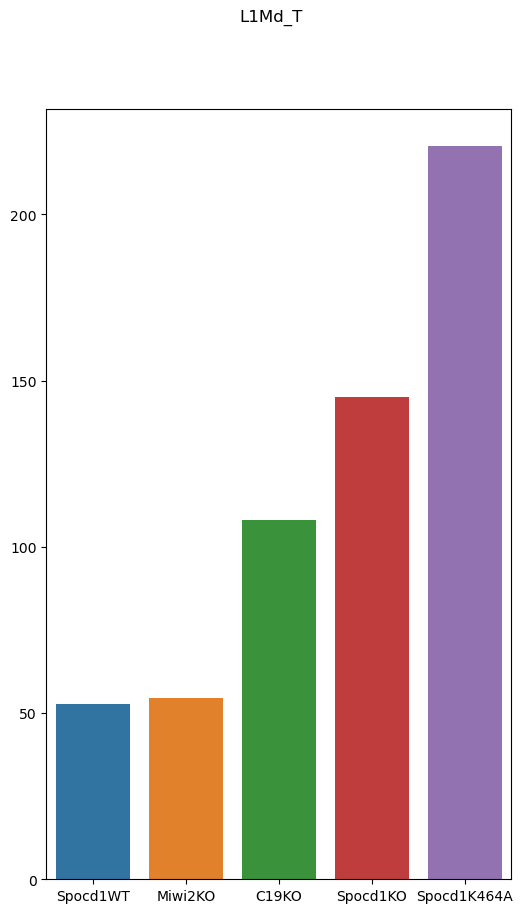

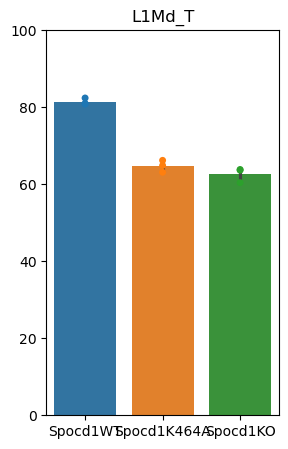

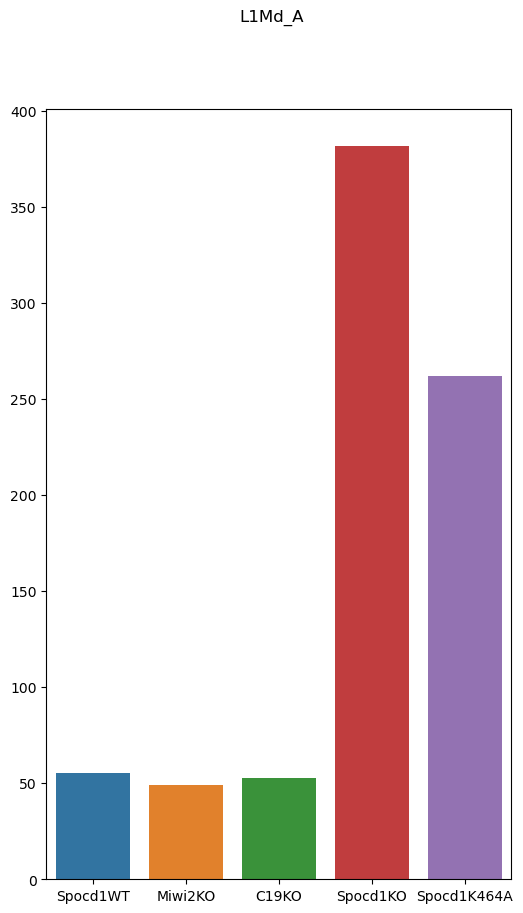

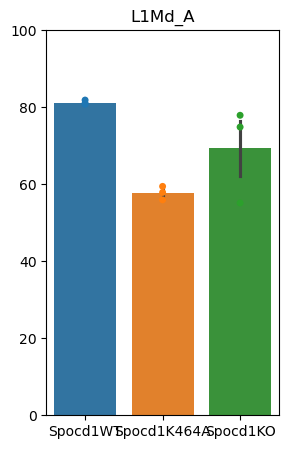

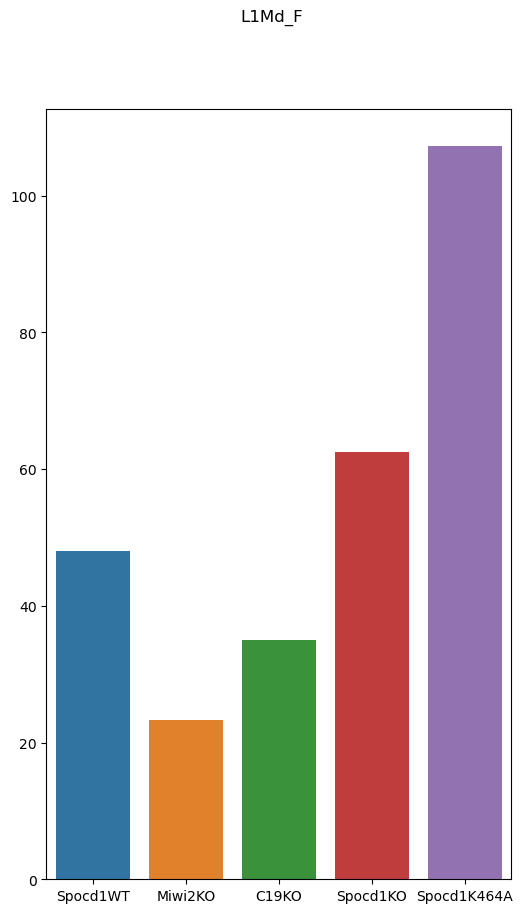

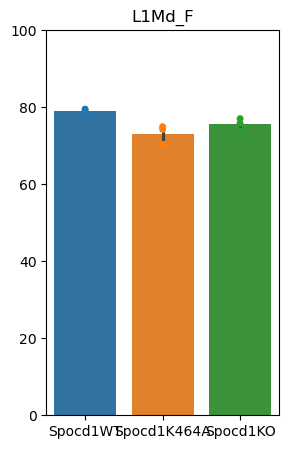

In [20]:
from pprint import pprint


LINE1_families = {
    'L1Md_Gf': ['L1Md_Gf'],
    'L1Md_T': ['L1Md_T'],
    'L1Md_A': ['L1Md_A'],
    'L1Md_F': ['L1Md_F', 'L1Md_F2', 'L1Md_F3']
}

for family, subfamilies in LINE1_families.items():
    family_data = get_family_met_data(divergence_data, subfamilies)
    plot_variance(family_data, family)
    pprint(median_plot_test(family_data, family)[1])